In [1]:
# Import libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import ruptures as rpt
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
import rpy2
%load_ext rpy2.ipython
import rpy2.ipython
import matplotlib.patches as mpatches
import itertools
from itertools import product
from scipy.ndimage import uniform_filter1d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_recall_fscore_support
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.stats import ttest_rel

# Data-generating functions

First, two data-generating methods were developed. Using generate_data_w_change_points method, signal with randomly distrubuted change points was genertaed. This method takes as input an array of means for normally distributed segments, along with additional parameters that define the characteristics of the segments. Method generate_data_w_change_points_and_anomalies uses the change point-generating funcion as imput, along with parameters specifying the anomalies to be inserted.


In [2]:
# Define signal generating functions

def generate_data_w_change_points(mu_choices=[1, 5], std_signal=1, 
                                min_segment_size_choices=[20,30,40], max_segment_size_choices=[50,100,150], 
                                total_length=1000, seed=12):
    # Set random seed for reproducibility
    np.random.seed(seed)
    signal = []
    change_points = []
    current_length = 0

    # Create customizable first segment
    min_segment_size = np.random.choice(min_segment_size_choices)
    max_segment_size = np.random.choice(max_segment_size_choices)
    segment_length = np.random.randint(min_segment_size, max_segment_size + 1)
    mu_0 = np.random.choice(mu_choices) 
    segment = np.random.normal(loc=mu_0, scale=std_signal, size=segment_length)
    signal.append(segment)
    current_length += segment_length
    change_points.append(current_length)
    
    while current_length < total_length:
        min_segment_size = np.random.choice(min_segment_size_choices)
        max_segment_size = np.random.choice(max_segment_size_choices)
        segment_length = np.random.randint(min_segment_size, max_segment_size + 1)
        if current_length + segment_length > total_length:
            segment_length = total_length - current_length  # last segment

        # Case for a single change point
        if min_segment_size_choices == [500] and max_segment_size_choices == [500]:
            possible_mus = [m for m in mu_choices if m != mu_0]
            mu = np.random.choice(possible_mus)
        else:
            mu = np.random.choice(mu_choices)
        
        segment = np.random.normal(loc=mu, scale=std_signal, size=segment_length)
        signal.append(segment)
        
        current_length += segment_length
        change_points.append(current_length)

    return np.concatenate(signal), change_points[:-1]

# generate_data_w_change_points_and_anomalies method builds on the top of generate_data_w_change_points, adding random anomalies.

def generate_data_w_change_points_and_anomalies(
    data_w_changepoints,
    seed=None,
    n_individual_anomalies=None,
    n_clusters=None,
    cluster_size=None,
    anomaly_std=None,
    indiv_anomal_mean = -5
):
    # Create a local RNG object 
    rng = np.random.default_rng(seed)
    signal = data_w_changepoints[0].copy()
    signal_length = len(signal)

    if n_individual_anomalies is None:
        n_individual_anomalies = rng.integers(5, 16)
    if n_clusters is None:
        n_clusters = rng.integers(3, 9)
    if cluster_size is None:
        cluster_size = rng.integers(3, 9)
    if anomaly_std is None:
        anomaly_std = rng.integers(1)

    all_anomaly_indices = set()
    anomaly_values = {}

    # ---- Clustered anomalies ----
    max_start = signal_length - cluster_size
    cluster_starts = rng.choice(max_start, size=n_clusters, replace=False)

    for start in cluster_starts:
        cluster_indices = np.arange(start, start + cluster_size)
        # Give each cluster a different standard deviation
        local_std = rng.uniform(0.5 * anomaly_std, 1 * anomaly_std)
        anomaly = rng.normal(-5, local_std, size=cluster_size)
        signal[cluster_indices] += anomaly
        all_anomaly_indices.update(cluster_indices)
        for i, a in zip(cluster_indices, anomaly):
            anomaly_values[i] = a

    # ---- Individual anomalies ----
    # Avoid overlapping with clustered ones
    available_indices = np.setdiff1d(np.arange(signal_length), list(all_anomaly_indices))
    individual_anomaly_indices = rng.choice(available_indices, size=n_individual_anomalies, replace=False)
    individual_anomalies = rng.normal(indiv_anomal_mean, anomaly_std, size=n_individual_anomalies)

    signal[individual_anomaly_indices] += individual_anomalies
    all_anomaly_indices.update(individual_anomaly_indices)
    for i, a in zip(individual_anomaly_indices, individual_anomalies):
            anomaly_values[i] = a

    return signal, data_w_changepoints[-1], anomaly_values


# Single change point detection 

### CuSum definition

In [3]:
def CuSum(samples, k, h, sigma=1):
    estimation_window=20  # window sizde of an initial mean estimation
    n = len(samples)
    change_points = []
    i = estimation_window 
    s_plus = 0
    s_minus = 0
    
    # Initial mean estimation
    mu = np.mean(samples[:estimation_window])
        
    while i < n:
        # Update statistics
        s_plus = max(0, s_plus + samples[i] - mu - k)
        s_minus = min(0, s_minus + samples[i] - mu + k)
        
        # Check for alarm
        if s_plus > h * sigma or np.abs(s_minus) > h * sigma:
            change_points.append(i)
            
            # Re-estimate the new mu from next few samples
            next_start = i + 1
            next_end = min(i + 1 + estimation_window, n)
            if next_end - next_start >= 10:  # window size not less than 10
                mu = np.mean(samples[next_start:next_end])
            else:
                mu = mu  # keep last mu if there is not enough data
            s_plus = 0
            s_minus = 0
            i = i + 1
            
        else:
            i += 1

    return change_points


### ARL0 and ARL1 definition

In this part ARL_0 and ARL_1 is measured on data with a single change point. The means of normally distributed segments  are interchangebly mu_0=1 and mu_1=5 with std = 1. Total lengh of the entire sequence is 1000. Subsequntly, a single anomaly is added to the data stream and the preformace metrics are reevaluated.

In [4]:
np.random.seed(12)

# Define Average Run Length 1    
def calculate_ARL1(
    n_simulations=1, 
    k_values=[], 
    h_values=[], 
    mu_1=1, 
    mu_2=5, 
    sigma=1, 
    seed = None,
    anomaly_index_range = None
):
    results = []

    # Test all k and h
    for k, h in itertools.product(k_values, h_values):
        differences = []
        np.random.seed(41)
        for i in range(n_simulations):
            seed = seed + i
            np.random.seed(seed)
            true_change_point = np.random.randint(400, 600)
            X_1 = np.random.normal(1,1,true_change_point)
            X_2 = np.random.normal(5,1,1000-true_change_point)
            signal_w_cp = np.concatenate((X_1, X_2))
            if anomaly_index_range is not None:
                anomaly_index = np.random.randint(anomaly_index_range[0],anomaly_index_range[1])
                signal_w_cp[anomaly_index] += np.random.normal(15, 1) 
            
            detected_change_point = CuSum(signal_w_cp, k, h, sigma)
            
            if detected_change_point is not None and detected_change_point[0] >= true_change_point:
                delay = detected_change_point[0] - true_change_point
                differences.append(delay)
        
        # Calculate ARL1 across multiple datasets for a given k, h pair
        ARL1 = np.mean(differences) if differences else float('inf')
        results.append((k, h, ARL1))

    # Display results
    print("\nARL1 results for different (k, h) values:\n")
    for k, h, ARL1 in results:
        print(f"k = {k}, h = {h} -> Estimated ARL1: {ARL1:.2f}")


# Run the ARL_1 simulation for datasets with a single change point
calculate_ARL1(
    n_simulations=1000, 
    k_values=[0.1, 0.5, 1], 
    h_values=[10,50,100,200], 
    mu_1=1, 
    mu_2=5, 
    seed=12,
    anomaly_index_range = None
)



ARL1 results for different (k, h) values:

k = 0.1, h = 10 -> Estimated ARL1: 1.14
k = 0.1, h = 50 -> Estimated ARL1: 10.06
k = 0.1, h = 100 -> Estimated ARL1: 21.74
k = 0.1, h = 200 -> Estimated ARL1: 44.84
k = 0.5, h = 10 -> Estimated ARL1: 2.24
k = 0.5, h = 50 -> Estimated ARL1: 13.63
k = 0.5, h = 100 -> Estimated ARL1: 27.96
k = 0.5, h = 200 -> Estimated ARL1: 56.86
k = 1, h = 10 -> Estimated ARL1: 2.82
k = 1, h = 50 -> Estimated ARL1: 16.34
k = 1, h = 100 -> Estimated ARL1: 32.96
k = 1, h = 200 -> Estimated ARL1: 66.49


In [5]:
# Define Average Run Length 0 (the average number of observations until a false alarm is triggered)
np.random.seed(12)
def ARL0_params(
    n_simulations = 1,
    k_values = [],
    h_values = [],
    no_samples = 1000,
    mu_1=1,
    anomaly_index_range = None
    ):
    results = []
    
    # Test all k and h
    for k,h in itertools.product(k_values, h_values):
        averages = []
        np.random.seed(41)
        for _ in range(n_simulations):
                    signal = np.random.normal(mu_1,1,1000)
                    if anomaly_index_range is not None:
                            anomaly_index = np.random.randint(anomaly_index_range[0],anomaly_index_range[1])
                            signal[anomaly_index] += np.random.normal(15, 1) 
                    detected_change_point = CuSum(signal, k, h, 1)
                    
                    
                    if detected_change_point:
                        averages.append(detected_change_point[0])
                    else:
                        averages.append(no_samples)
        ARL0 = np.mean(averages)
        results.append((k, h, ARL0))
    
    # Display results
    print("ARL0 results for different (k, h) values:\n")
    for k, h, ARL0 in results:
        print(f"k = {k}, h = {h} -> Estimated ARL0: {ARL0:.2f}")

# Run the ARL_0 simulation for datasets with a single change point
ARL0_params(
    n_simulations=1000, 
    k_values=[0.1, 0.5, 1], 
    h_values=[10,50,100,200],  
    no_samples = 1000,
    mu_1=1,
    anomaly_index_range = None)   

ARL0 results for different (k, h) values:

k = 0.1, h = 10 -> Estimated ARL0: 103.02
k = 0.1, h = 50 -> Estimated ARL0: 638.76
k = 0.1, h = 100 -> Estimated ARL0: 807.70
k = 0.1, h = 200 -> Estimated ARL0: 948.50
k = 0.5, h = 10 -> Estimated ARL0: 813.25
k = 0.5, h = 50 -> Estimated ARL0: 992.84
k = 0.5, h = 100 -> Estimated ARL0: 998.30
k = 0.5, h = 200 -> Estimated ARL0: 1000.00
k = 1, h = 10 -> Estimated ARL0: 999.43
k = 1, h = 50 -> Estimated ARL0: 1000.00
k = 1, h = 100 -> Estimated ARL0: 1000.00
k = 1, h = 200 -> Estimated ARL0: 1000.00


The best set of parameters: k = 1, h = 10 -> Estimated ARL0: 999.43; Estimated ARL1: 2.82

### Single change point detection - impact of anomaly

In [6]:
# Run the ARL_1 simulation for datasets with a single change point and anomaly
calculate_ARL1(
    n_simulations=1000, 
    k_values=[0.1, 0.5, 1], 
    h_values=[10,50,100,200], 
    mu_1=1, 
    mu_2=5, 
    seed=12,
    anomaly_index_range = [0,100]
)


ARL1 results for different (k, h) values:

k = 0.1, h = 10 -> Estimated ARL1: inf
k = 0.1, h = 50 -> Estimated ARL1: 10.61
k = 0.1, h = 100 -> Estimated ARL1: 21.82
k = 0.1, h = 200 -> Estimated ARL1: 44.74
k = 0.5, h = 10 -> Estimated ARL1: 2.75
k = 0.5, h = 50 -> Estimated ARL1: 13.73
k = 0.5, h = 100 -> Estimated ARL1: 28.31
k = 0.5, h = 200 -> Estimated ARL1: 58.96
k = 1, h = 10 -> Estimated ARL1: 3.63
k = 1, h = 50 -> Estimated ARL1: 17.33
k = 1, h = 100 -> Estimated ARL1: 35.19
k = 1, h = 200 -> Estimated ARL1: 71.27


In [7]:
# Run the ARL_0 simulation for datasets with a single anomaly
ARL0_params(
    n_simulations=1000, 
    k_values=[0.1, 0.5, 1], 
    h_values=[10,50,100,200],  
    no_samples = 1000,
    mu_1=1,
    anomaly_index_range = [0,100])   

ARL0 results for different (k, h) values:

k = 0.1, h = 10 -> Estimated ARL0: 49.06
k = 0.1, h = 50 -> Estimated ARL0: 522.51
k = 0.1, h = 100 -> Estimated ARL0: 688.12
k = 0.1, h = 200 -> Estimated ARL0: 826.35
k = 0.5, h = 10 -> Estimated ARL0: 71.68
k = 0.5, h = 50 -> Estimated ARL0: 868.50
k = 0.5, h = 100 -> Estimated ARL0: 905.45
k = 0.5, h = 200 -> Estimated ARL0: 951.83
k = 1, h = 10 -> Estimated ARL0: 184.42
k = 1, h = 50 -> Estimated ARL0: 990.84
k = 1, h = 100 -> Estimated ARL0: 995.56
k = 1, h = 200 -> Estimated ARL0: 998.70


The best set of parameters: k = 1, h = 50 -> Estimated ARL0: 990.84; Estimated ARL1: 17.33
Most of  the ARL0 results are worse than in the experiments with data without an anomaly.

# Single anomaly detection

### Local Outlier Factor tuning function

In [8]:
# Define LOF tunig function
def tune_LOF(data_generating_function, no_neighbours=[30,50,100,150,400], contamination_range= [0.03,0.06, 0.09], n_simulations=100, seed=12):
    np.random.seed(seed)
    f1_scores = []
    best_detected_anomalies = None

    
    for c in contamination_range:
            for n in no_neighbours:
        
                # Find the best n
                best_n= None
                best_score = 0
                for sim_idx in range(n_simulations):
                    # Generate dataset with anomalies
                    current_simulation_seed = seed + sim_idx
                    data, _, true_anomalies = data_generating_function(seed=current_simulation_seed)
                    data_reshaped = data.reshape(-1, 1)
                    lof = LocalOutlierFactor(n_neighbors=n, contamination=c)
                    detected_anomalies = lof.fit_predict(data_reshaped)
        
                    # Map LOF output
                    y_pred = (detected_anomalies == -1).astype(int)
        
                    # Ground truth anomalies
                    y_true = np.zeros(len(data), dtype=int)
                    y_true[list(true_anomalies.keys())] = 1
        
                    
                    _, _, f1, _ = precision_recall_fscore_support(
                    list(y_true), list(y_pred), average='binary')
                    if f1 > best_score:
                        best_score = f1
                        best_detected_anomalies = detected_anomalies
                    
    
                    f1_scores.append(f1)

    return f1_scores, (best_score, best_detected_anomalies)



In [9]:
# Run anomaly detection simulation for datasets with a single anomaly
f1_lof_results, _ = tune_LOF(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    [np.random.normal(1, 1, 1000)],
    n_individual_anomalies=1,
    indiv_anomal_mean = -5,
    n_clusters=0,
    cluster_size=0,
    anomaly_std=1,    
    **kwargs),
    no_neighbours=[5,10,20],
    contamination_range= [0.001],
    n_simulations=100, seed=12)

In [10]:
# Run anomaly detection simulation for datasets with a single anomaly and a change point
f1_lof_results_w_cps, _ = tune_LOF(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    generate_data_w_change_points(
            mu_choices=[1,5],
            std_signal=1,
            total_length=1000,
            min_segment_size_choices=[500], # together with max_segment_size_choices=[500] ensures occurence of a single change point
            max_segment_size_choices=[500],
            **kwargs), 
    n_individual_anomalies=1,
    indiv_anomal_mean = -5,
    n_clusters=0,
    cluster_size=0,
    anomaly_std=1,    
    **kwargs),
    no_neighbours=[5,10,20],
    contamination_range= [0.001],
    n_simulations=100, seed=12)

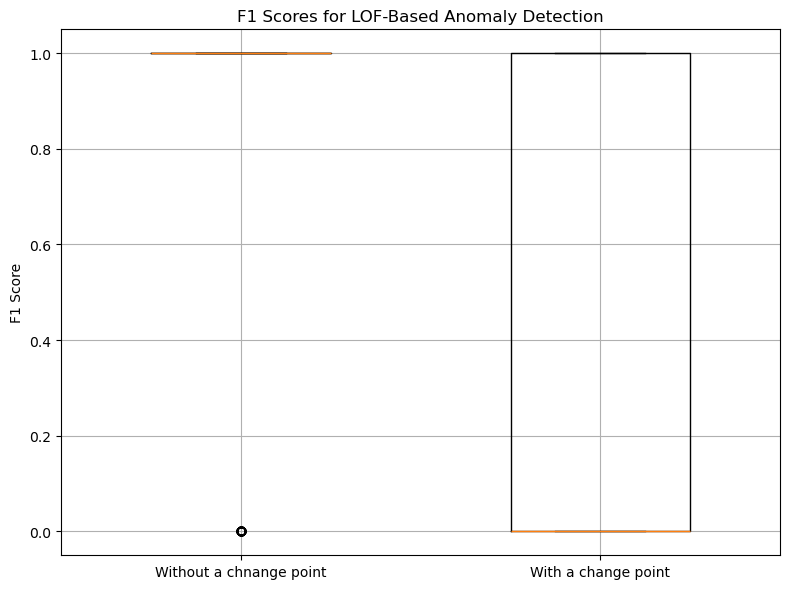

In [11]:
# Plot F1-scores for the anomly detecttion scenarios
plt.figure(figsize=(8, 6))

# Plot two boxplots at different positions
plt.boxplot(f1_lof_results, widths=0.5, positions=[1])
plt.boxplot(f1_lof_results_w_cps, widths=0.5, positions=[2])

# Set x-axis labels
plt.xticks([1, 2], ['Without a chnange point', 'With a change point'])

# Add title and axis labels
plt.title('F1 Scores for LOF-Based Anomaly Detection')
plt.ylabel('F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
# P-value test
stat, p = ttest_rel(f1_lof_results, f1_lof_results_w_cps)
print("Paired t-test p-value:", p)


Paired t-test p-value: 2.3222041267690683e-23


# Multiple Change Points and Anomaly Detection

## Develop CPD algorithms

### CuSum parameter tuning

In [13]:
# Define CuSum tuning function
def tune_cusum_parameters(data_generating_function, k_values, h_values, n_sim=1000, tolerance=10,  seed=None):
    results = []
    best_f1_score = 0
    f1_all = []

    # Set random seed for the tuning process reproducibility
    np.random.seed(seed)
    
    for k in k_values:
        for h in h_values:
            f1_scores = []

            for sim_idx in range(n_sim):
                total_tp = total_fp = total_fn = 0
                current_simulation_seed = seed + sim_idx  # Generate a new seed for data generation
                X, true_cps = data_generating_function(seed=current_simulation_seed)
                detected_cps = CuSum(X, k=k, h=h, sigma=1)

                matched_true = set()
                matched_detected = set()

                for i, cp in enumerate(true_cps):
                    for j, det_cp in enumerate(detected_cps):
                        if abs(det_cp - cp) <= tolerance and j not in matched_detected:
                            total_tp += 1
                            matched_true.add(i)
                            matched_detected.add(j)
                            break

                total_fp = len(detected_cps) - len(matched_detected)
                total_fn = len(true_cps) - len(matched_true)
                

                # Precision and recall
                precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
                recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
                # F1 scoring
                f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

                f1_scores.append(f1)
                f1_all.append(f1)
                
            avg_f1 = float(np.mean(f1_scores))
            results.append({
                "k": k,
                "h": h,
                "F1-score": avg_f1
                })
            if avg_f1 > best_f1_score:
                best_f1_score = avg_f1
                best_k = k
                best_h = h
    
    return (best_k, best_h), best_f1_score, f1_all

In [14]:
# Run the CuSum simulation with multiple k and h values on data with multiple change points
(best_k, best_h), best_f1_score, cusum__f1_results = tune_cusum_parameters(
    data_generating_function=lambda **kwargs: generate_data_w_change_points(
        mu_choices=[1, 5],
        std_signal=1,
        total_length=1000,
        **kwargs 
    ),
    k_values=[0.1, 0.5, 1, 1.5, 2, 2.5, 3],
    h_values=[1,2,3,4,5,10,15,20], 
    n_sim=100,
    tolerance=10,  # tolerance window for detection
    seed=12 # main seed
)
# Illustrative best (k,h) for data with change points; results are not conclusive
print(f"Average best (k,h) for datasets with change points: {(best_k, best_h)}, F1-score: {np.round(best_f1_score,3)} ")

Average best (k,h) for datasets with change points: (2, 2), F1-score: 0.644 


### SPRT and parameter tuning

In [15]:
# Define SPRT algorithm
def Sprt(samples, u, mu_0=1, sigma_0=1, mu_1=5, sigma_1=1):
    Sn_up = 0   # upward mu change
    Sn_down = 0 # downward mu change
    change_points = []
    epsilon = 1e-12  # to avoid log(0)

    for i, x in enumerate(samples):
        # Log-likelihoods for upward and downward change
        llr_up = np.log(norm.pdf(x, loc=mu_1, scale=sigma_1) + epsilon) - np.log(norm.pdf(x, loc=mu_0, scale=sigma_0) + epsilon)
        Sn_up = max(0, Sn_up + llr_up)


        llr_down = np.log(norm.pdf(x, loc=mu_0, scale=sigma_0) + epsilon) - np.log(norm.pdf(x, loc=mu_1, scale=sigma_1) + epsilon)
        Sn_down = max(0, Sn_down + llr_down)

        # If either statistic exceeds threshold
        if Sn_up > u or Sn_down > u:
            change_points.append(i)
            Sn_up = 0
            Sn_down = 0

    return change_points

In [16]:
# Define SPRT tuning function
def tune_sprt_thresholds(data_generating_function, u_values, n_sim=1000, tolerance=10,
                         mu_0=1, sigma_0=1, mu_1=5, sigma_1=1, seed = None):
    results = []
    best_u = None
    best_f1_score = -1
    f1_all = []

    # Main seed for the tuning process reproducibility
    np.random.seed(seed)

    for u in u_values:
        f1_scores = []
        avg_f1 = 0

        for sim_idx in range(n_sim):
            total_tp = total_fp = total_fn = 0
            current_simulation_seed = seed + sim_idx  # Generate a new seed for data generation
            X, true_cps = data_generating_function(seed=current_simulation_seed)
            detected_cps = Sprt(X, u=u, mu_0=mu_0, sigma_0=sigma_0, mu_1=mu_1, sigma_1=sigma_1)

            matched_true = set()
            matched_detected = set()

            for i, cp in enumerate(true_cps):
                for j, det_cp in enumerate(detected_cps):
                    if abs(det_cp - cp) <= tolerance and j not in matched_detected:
                        total_tp += 1
                        matched_true.add(i)
                        matched_detected.add(j)
                        break

            total_fn = len(true_cps) - len(matched_true) # tak na prawde to jest changeppoint
            total_fp = len(detected_cps) - len(matched_detected)

            precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
            recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
            f1_scores.append(f1)
            f1_all.append(f1)
                
        avg_f1 = float(np.mean(f1_scores))


        results.append({
            "u": u,
            "F1-score": avg_f1
            })

        if avg_f1 > best_f1_score:
            best_f1_score = avg_f1
            best_u = u

    return best_u, best_f1_score, f1_all

In [17]:
# Run the SPRT simulation with multiple u values on data with multiple change points
best_u, best_f1_score, sprt__f1_results = tune_sprt_thresholds(
    data_generating_function=lambda **kwargs: generate_data_w_change_points(mu_choices=[1, 5], std_signal=1,
                                                                    total_length=1000, **kwargs),
    u_values=np.linspace(150,240,10),
    n_sim=100,
    mu_0=1, 
    sigma_0=1, 
    mu_1=5, 
    sigma_1=1,
    tolerance=10,
    seed = 12 # main seed
)
# Illustrative best u for data with change points; results are not conclusive
print(f"Tuned u = {best_u}. Best f1_score = {np.round(best_f1_score,3)}")

Tuned u = 160.0. Best f1_score = 0.376


### Offline setting - ruptures binary segmentation

In [18]:
# Define binary segmentatation tuning function
def tune_ruptures(data_generating_function, w_width, penalty_values, n_sim = 100, tolerance = 10, seed = None):
    best_f1_score = 0
    f1_all = []
    results = []
    for width in w_width:
        for pen in penalty_values:
            f1_scores = []
            avg_f1 = 0
            for sim_idx in range(n_sim):
                total_tp = total_fp = total_fn = 0
                current_simulation_seed = seed + sim_idx  # Generate a new seed for data generation
                X, true_cps = data_generating_function(seed=current_simulation_seed)
                algo = rpt.Window(width=width, model="l1").fit(X)
                detected_cps = algo.predict(pen=pen)

                total_fp = 0 
                total_fn = 0
                matched_true = set()
                matched_detected = set()

                for i, cp in enumerate(true_cps):
                    for j, det_cp in enumerate(detected_cps):
                        if abs(det_cp - cp) <= tolerance and j not in matched_detected:
                            total_tp += 1
                            matched_true.add(i)
                            matched_detected.add(j)
                            break

                total_fp = len(detected_cps) - len(matched_detected)
                total_fn = len(true_cps) - len(matched_true)
                

                # Precision, recall and F1-score
                precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
                recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
                # F1 scoring
                f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

                f1_scores.append(f1)
                f1_all.append(f1)
                
            avg_f1 = float(np.mean(f1_scores))
            results.append({
                "width": width,
                "penalty": pen,
                "F1-score": avg_f1
                })
            if avg_f1 > best_f1_score:
                best_f1_score = avg_f1
                best_window_width = width
                best_penalty = pen
    
    return best_window_width, best_penalty, best_f1_score, f1_all


In [19]:
# Run the binary segmentation (with sliding window) simulation with multiple window width and penalty values 
# on data with multiple change points
best_window_width, best_penalty, best_f1_score, ruptures_f1_results = tune_ruptures(
    data_generating_function=lambda **kwargs: generate_data_w_change_points(mu_choices=[1, 5], std_signal=1,
                                                                    total_length=1000, **kwargs),
    w_width=[10, 30, 50, 80, 100],
    penalty_values = [0.1, 0.3, 0.5, 1, 5], 
    n_sim = 100, 
    seed = 12)
# Illustrative best (w,p) for data with change points; results are not conclusive
print(f"Tuned width = {best_window_width} and penalty = {best_penalty}. Best f1_score = {np.round(best_f1_score,3)}")

Tuned width = 50 and penalty = 0.1. Best f1_score = 0.572


# CPD in the presence of outliers

In [20]:
# Run the CuSum simulation with multiple (k,h) values on data with multiple change points and anomalies
(best_k, best_h), best_f1_score, cusum__f1_results_w_outliers  = tune_cusum_parameters(
    data_generating_function=lambda **kwargs: generate_data_w_change_points_and_anomalies(
        generate_data_w_change_points(
            mu_choices=[1, 5],
            std_signal=1,
            total_length=1000,
            **kwargs
        ),
        seed=12,
        n_individual_anomalies=10,
        n_clusters=40,
        cluster_size=4,
        anomaly_std=1,
        indiv_anomal_mean = -5
        )[:2],  # only keep signal and true change points
    k_values=[0.1, 0.5, 1, 1.5, 2, 2.5, 3],
    h_values=[1,2,3,4,5,10,15,20],  
    n_sim=100,
    tolerance=10,
    seed = 12 # main seed
)
# Illustrative best (k,h) for data with change points and anomalies; results are not conclusive
print(f"Tuned (k,h) for data with change points: {(best_k, best_h)}, F1-score: {np.round(best_f1_score,3)} ")

Tuned (k,h) for data with change points: (1, 20), F1-score: 0.515 


In [21]:
# Run the SPRT simulation with multiple u values on data with multiple change points and anomalies
best_u, best_f1_score, sprt__f1_results_w_outliers  = tune_sprt_thresholds(
    data_generating_function=lambda **kwargs: generate_data_w_change_points_and_anomalies(
        generate_data_w_change_points(
            mu_choices=[1, 5],
            std_signal=1,
            total_length=1000,
            **kwargs
        ),
        seed=12,
        n_individual_anomalies=10,
        n_clusters=40,
        cluster_size=4,
        anomaly_std=1,
        indiv_anomal_mean = -5
        )[:2],
    u_values=np.linspace(150,240,10),
    n_sim=100,
    tolerance=10,
    seed=12 # main seed
)
# Illustrative best u for data with change points and anomalies; results are not conclusive
print(f"Tuned u = {best_u}. Best f1_score = {best_f1_score}")

Tuned u = 170.0. Best f1_score = 0.37062245702370566


In [22]:
# Run binary segmentation (with sliding window) simulation with multiple window width and penalty values 
# on data with multiple change points and anomalies
best_window_width, best_penalty, best_f1_score, ruptures_f1_results_w_outliers = tune_ruptures(
    data_generating_function=lambda **kwargs: generate_data_w_change_points_and_anomalies(
        generate_data_w_change_points(
            mu_choices=[1, 5],
            std_signal=1,
            total_length=1000,
            **kwargs
        ),
        seed=12,
        n_individual_anomalies=10,
        n_clusters=40,
        cluster_size=4,
        anomaly_std=1,
        indiv_anomal_mean = -5
        )[:2],
    w_width=[10, 30, 50, 80, 100],
    penalty_values = [0.1, 0.3, 0.5, 1, 5], 
    n_sim = 100, 
    seed = 12)
# Illustrative best (w,p) for data with change points and anomalies; results are not conclusive
print(f"Tuned width = {best_window_width} and penalty = {best_penalty}. Best f1_score = {best_f1_score}")

Tuned width = 30 and penalty = 0.1. Best f1_score = 0.5286139666774762


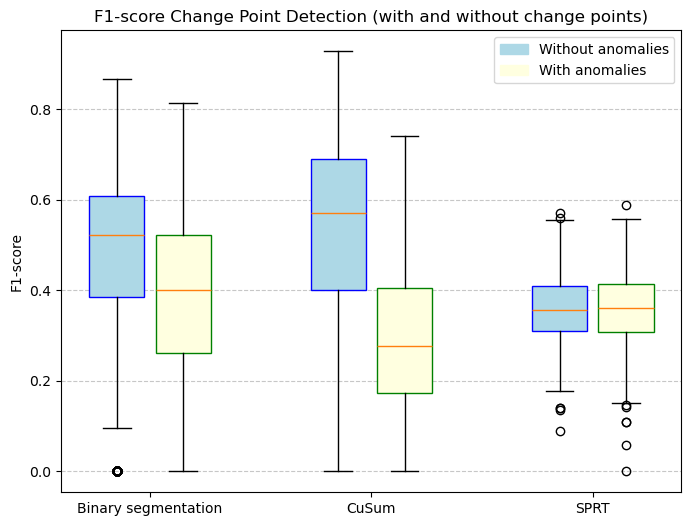

In [23]:
# Box plot for the change point detection F1-Score results
# Group data
data_no_anomalies = [ruptures_f1_results, cusum__f1_results, sprt__f1_results]
data_w_anomalies = [ruptures_f1_results_w_outliers, cusum__f1_results_w_outliers, sprt__f1_results_w_outliers]
labels = ['Binary segmentation', 'CuSum', 'SPRT']

# Positions for grouped boxplots
positions_no_a = np.arange(len(labels)) * 2.0
positions_w_a = positions_no_a + 0.6

plt.figure(figsize=(8, 6))
plt.boxplot(data_no_anomalies, positions=positions_no_a, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.boxplot(data_w_anomalies, positions=positions_w_a, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='lightyellow', color='green'))

plt.xticks(positions_no_a + 0.3, labels)
plt.ylabel('F1-score')
plt.title('F1-score Change Point Detection (with and without change points)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set legend
patch_no_a = mpatches.Patch(color='lightblue', label='Without anomalies')
patch_w_a = mpatches.Patch(color='lightyellow', label='With anomalies')
plt.legend(handles=[patch_no_a, patch_w_a], loc='best')

plt.show()


In [24]:
# Calculate and display the means
means_no_anomalies = [np.mean(results) for results in data_no_anomalies]
means_w_anomalies  = [np.mean(results) for results in data_w_anomalies]

for label, mean_no, mean_w in zip(labels, means_no_anomalies, means_w_anomalies):
    print(f"{label}: mean without anomalies = {mean_no:.4f}, mean with anomalies = {mean_w:.4f}")


Binary segmentation: mean without anomalies = 0.4761, mean with anomalies = 0.3815
CuSum: mean without anomalies = 0.5216, mean with anomalies = 0.2940
SPRT: mean without anomalies = 0.3598, mean with anomalies = 0.3573


In [25]:
# P-value tests
stat, p = ttest_rel(ruptures_f1_results_w_outliers, ruptures_f1_results)
print("Paired t-test p-value for binary segmentation:", p)

stat, p = ttest_rel(cusum__f1_results_w_outliers, cusum__f1_results)
print("Paired t-test p-value for CuSum:", p)

stat, p = ttest_rel(sprt__f1_results_w_outliers, sprt__f1_results)
print("Paired t-test p-value for SPRT:", p)

Paired t-test p-value for binary segmentation: 2.4316443164784965e-87
Paired t-test p-value for CuSum: 0.0
Paired t-test p-value for SPRT: 0.37100253940309


# Anomlay Detection

### K-Means++

In [26]:
# Define K-Means++ tunig function
def tune_kmeans(data_generating_function, k_range=(2, 7), percentile_range =[95,96,97,98,99], n_simulations=100, seed=12):
    np.random.seed(seed)
    f1_scores = []
    best_f1_score = 0
    
    final_best_detection = None

    for percentile in percentile_range:
        for sim_idx in range(n_simulations):
            # Generate dataset with anomalies
            current_simulation_seed = seed + sim_idx
            data, _, true_anomalies = data_generating_function(seed=current_simulation_seed)
            data_reshaped = data.reshape(-1, 1)
    
            # Find the best k using silhouette score
            best_k = None
            best_silhouette_score = 0
            for k in range(k_range[0], k_range[1] + 1):
                kmeans = KMeans(n_clusters=k, init='k-means++', random_state=current_simulation_seed)
                labels = kmeans.fit_predict(data_reshaped)
                score = silhouette_score(data_reshaped, labels)
                if score > best_silhouette_score:
                    best_silhouette_score = score
                    best_k = k
    
            # Run K-Means with the best k
            kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=current_simulation_seed)
            labels = kmeans.fit_predict(data_reshaped)
    
            _, distances = pairwise_distances_argmin_min(data_reshaped, kmeans.cluster_centers_)
    
            # Determine anomalies based on distances
            threshold = np.percentile(distances, percentile)
            detected_anomalies = set(np.where(distances >= threshold)[0])
    
            y_true = np.zeros(len(data), dtype=int)
            y_true[list(true_anomalies.keys())] = 1  # set anomalies to 1
            
            y_pred = np.zeros(len(data), dtype=int)
            y_pred[list(detected_anomalies)] = 1
            
            # Calculate F1-score
            _, _, f1, _ = precision_recall_fscore_support(
                list(y_true), list(y_pred), average='binary')
            if f1> best_f1_score:
                best_f1_score = f1
                final_best_detection = detected_anomalies
    
            f1_scores.append(f1)

    return f1_scores, (best_f1_score, final_best_detection)


In [27]:
# Run K-Means++ simulation on data with multiple anomalies
f1_kmeans_results, _ = tune_kmeans(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    [np.random.normal(1, 1, 1000)],
    indiv_anomal_mean = -15,
    **kwargs
), n_simulations=100, seed=12)

### Local factor

In [28]:
# Run LOF simulation on data with multiple anomalies
f1_lof_results, _ = tune_LOF(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    [np.random.normal(1, 1, 1000)],
    indiv_anomal_mean = -15,
    **kwargs
), n_simulations=100, seed=12)


# Anomlay Detection in the presence of change points

In [29]:
# Run K-Means++ simulation on data with multiple anomalies and change points
f1_kmeans_results_w_cps, _ = tune_kmeans(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    generate_data_w_change_points(
            mu_choices=[1,2,3,4,5],
            std_signal=1,
            total_length=1000,
            **kwargs), 
    indiv_anomal_mean = -15,
    **kwargs
), n_simulations=100, seed=12)

In [30]:
# Run LOF simulation on data with multiple anomalies and change points
f1_lof_results_w_cps, _ = tune_LOF(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    generate_data_w_change_points(
            mu_choices=[1,2,3,4,5],
            std_signal=1,
            total_length=1000,
            **kwargs),
    indiv_anomal_mean = -15,
    **kwargs
), n_simulations=100, seed=12)


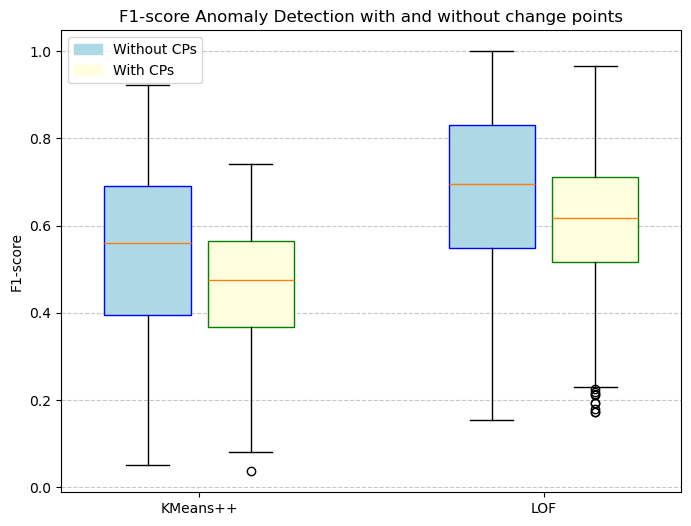

In [31]:
# Box plot for the anomaly detection F1-Score results
# Group data
data_no_cps = [f1_kmeans_results, f1_lof_results]
data_with_cps = [f1_kmeans_results_w_cps, f1_lof_results_w_cps]
labels = ['KMeans++', 'LOF']

# Positions for grouped boxplots
positions_no_cps = np.arange(len(labels)) * 2.0
positions_w_cps = positions_no_cps + 0.6

plt.figure(figsize=(8, 6))
plt.boxplot(data_no_cps, positions=positions_no_cps, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.boxplot(data_with_cps, positions=positions_w_cps, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='lightyellow', color='green'))

plt.xticks(positions_no_cps + 0.3, labels)
plt.ylabel('F1-score')
plt.title('F1-score Anomaly Detection with and without change points')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set legend
patch_no_cps = mpatches.Patch(color='lightblue', label='Without CPs')
patch_w_cps = mpatches.Patch(color='lightyellow', label='With CPs')
plt.legend(handles=[patch_no_cps, patch_w_cps], loc='best')

plt.show()


In [32]:
# Calculate means
means_no_cps = [np.mean(results) for results in data_no_cps]
means_w_cps  = [np.mean(results) for results in data_with_cps]

for label, mean_no, mean_w in zip(labels, means_no_cps, means_w_cps):
    print(f"{label}: mean without change points = {mean_no:.4f}, mean with change points = {mean_w:.4f}")

KMeans++: mean without change points = 0.5419, mean with change points = 0.4574
LOF: mean without change points = 0.6716, mean with change points = 0.6152


In [33]:
# P-value tests
stat, p = ttest_rel(f1_kmeans_results, f1_kmeans_results_w_cps)
print("Paired t-test p-value for K-Means++:", p)

stat, p = ttest_rel(f1_lof_results, f1_lof_results_w_cps)
print("Paired t-test p-value for LOF:", p)

Paired t-test p-value for K-Means++: 4.723352075193672e-27
Paired t-test p-value for LOF: 2.4002152819888774e-48


### Anomaly Detection with different anomaly characteristics

In [34]:
# Run K-Means++ simulation on data with smaller anomalies
f1_kmeans_results, _ = tune_kmeans(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    [np.random.normal(1, 1, 1000)],
    indiv_anomal_mean = -1,
    **kwargs
), n_simulations=100, seed=12)

In [35]:

# Run K-Means++ simulation on data with smaller anomalies and change points
f1_kmeans_results_w_cps, _ = tune_kmeans(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    generate_data_w_change_points(
            mu_choices=[1,2,3,4,5],
            std_signal=1,
            total_length=1000,
            **kwargs), 
    indiv_anomal_mean = -1,
    **kwargs
), n_simulations=100, seed=12)

In [36]:
# Run LOF simulation on data with smaller anomalies
f1_lof_results, _ = tune_LOF(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    [np.random.normal(1, 1, 1000)],
    indiv_anomal_mean = -1,
    **kwargs
), n_simulations=100, seed=12)

In [37]:
# Run LOF simulation on data with multiple anomalies and change points
f1_lof_results_w_cps, _ = tune_LOF(data_generating_function= lambda **kwargs: generate_data_w_change_points_and_anomalies(
    generate_data_w_change_points(
            mu_choices=[1,2,3,4,5],
            std_signal=1,
            total_length=1000,
            **kwargs),
    indiv_anomal_mean = -1,
    **kwargs
), n_simulations=100, seed=12)

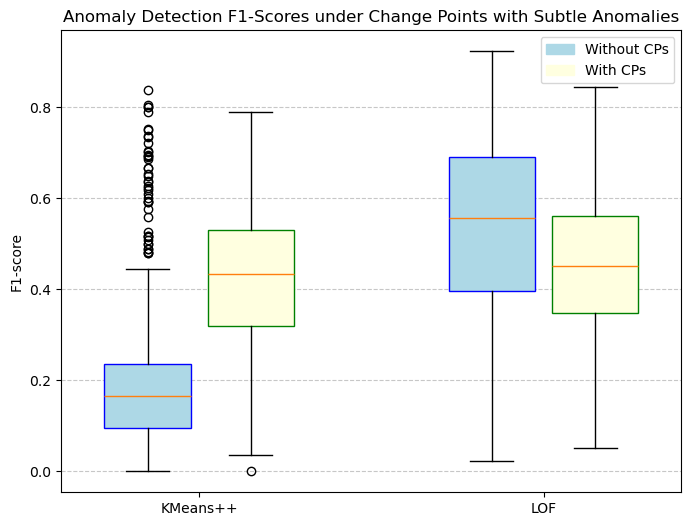

In [38]:
# Box plot for the anomaly detection F1-Score results
# Group data
data_no_cps = [f1_kmeans_results, f1_lof_results]
data_with_cps = [f1_kmeans_results_w_cps, f1_lof_results_w_cps]
labels = ['KMeans++', 'LOF']

# Positions for grouped boxplots
positions_no_cps = np.arange(len(labels)) * 2.0
positions_w_cps = positions_no_cps + 0.6

plt.figure(figsize=(8, 6))
plt.boxplot(data_no_cps, positions=positions_no_cps, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.boxplot(data_with_cps, positions=positions_w_cps, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='lightyellow', color='green'))

plt.xticks(positions_no_cps + 0.3, labels)
plt.ylabel('F1-score')
plt.title('Anomaly Detection F1-Scores under Change Points with Subtle Anomalies')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set legend
patch_no_cps = mpatches.Patch(color='lightblue', label='Without CPs')
patch_w_cps = mpatches.Patch(color='lightyellow', label='With CPs')
plt.legend(handles=[patch_no_cps, patch_w_cps], loc='best')

plt.show()


# CPD - enhanced Anomaly Detection

# Network data upload

In [39]:
# Import network data
data = pd.read_csv("network_dataset_labeled.csv")
# Select throughput as univariate time series
time = data["timestamp"].copy()
throughput = np.array(data["throughput"].copy())
true_anomalies = data["anomaly_throughput"].copy()
true_anomaly_indecies = np.where(true_anomalies == 1)[0]

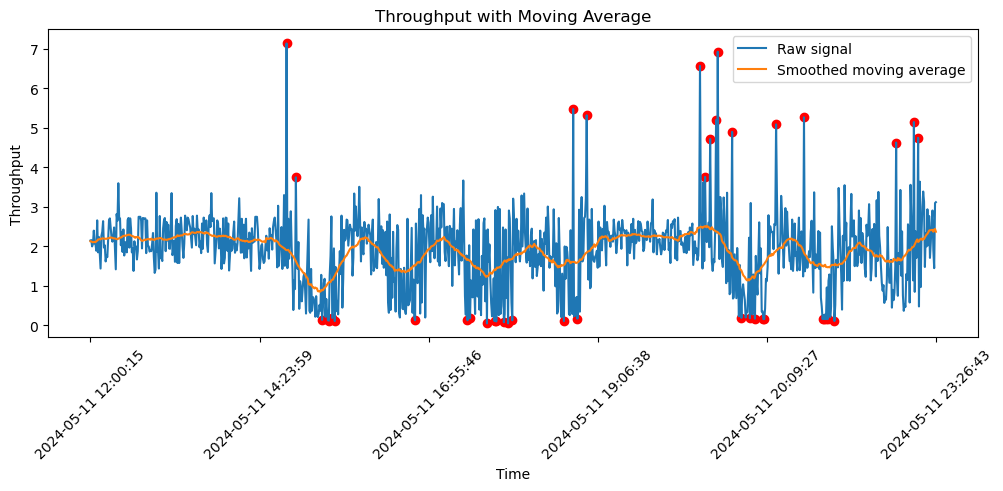

In [40]:
# Analyse possible trend patterns
smoothed = uniform_filter1d(throughput, size=50)
plt.figure(figsize=(12, 4))
plt.plot(time, throughput, label="Raw signal")
plt.plot(time, smoothed, label="Smoothed moving average")
plt.scatter(time.iloc[true_anomaly_indecies], [throughput[i] for i in true_anomaly_indecies], color = 'red')

# Show only 6 ticks
n_labels = 6
tick_indices = np.linspace(0, len(time)-1, n_labels, dtype=int)
plt.xticks(time.iloc[tick_indices], rotation=45)
plt.legend()
plt.title("Throughput with Moving Average")
plt.xlabel("Time")
plt.ylabel("Throughput")
plt.show()

# Change Point Detection on Network Data

### CUSUM

In [41]:
# Run CuSum on network data
k_values = [0.5, 1, 1.5]
h_values = [10, 20, 30]
valid_params_cusum = []

for k in k_values:
    for h in h_values:
        cps = CuSum(throughput, k=k, h=h, sigma=1)
        if len(cps) <= 20 and len(cps) > 2: # Limiataiton on no. cps
            valid_params_cusum.append({
                "k": k,
                "h": h,
                "num_cps": len(cps),
                "cps": cps
            })

# Print all valid parameter sets
for vp in valid_params_cusum:
    print(f"k={vp['k']}, h={vp['h']} -> {vp['num_cps']} change points")

k=0.5, h=10 -> 11 change points
k=0.5, h=20 -> 4 change points
k=0.5, h=30 -> 3 change points


### Ruptures binary search

In [42]:
# Run Binary Segmentation on network data
window_width = [10, 20, 30, 40, 50]
penalty_values = [0.1, 0.5, 1]
valid_params_ruptures = []

for width in window_width:
    for p in penalty_values:
        X = rpt.Window(width=width, model="l1").fit(throughput)
        cps_ruptures_throughput = X.predict(pen=p)[:-1]
        if len(cps_ruptures_throughput) <= 20 and len(cps_ruptures_throughput) > 7:
            valid_params_ruptures.append({
                "window_width": width,
                "penalty": p,
                "num_cps": len(cps_ruptures_throughput),
                "cps": cps_ruptures_throughput
            })

# Print all valid parameter sets
for vp in valid_params_ruptures:
    print(f"window_width={vp['window_width']}, penalty={vp['penalty']} -> {vp['num_cps']} change points")

window_width=40, penalty=0.1 -> 17 change points
window_width=50, penalty=0.1 -> 9 change points
window_width=50, penalty=0.5 -> 9 change points


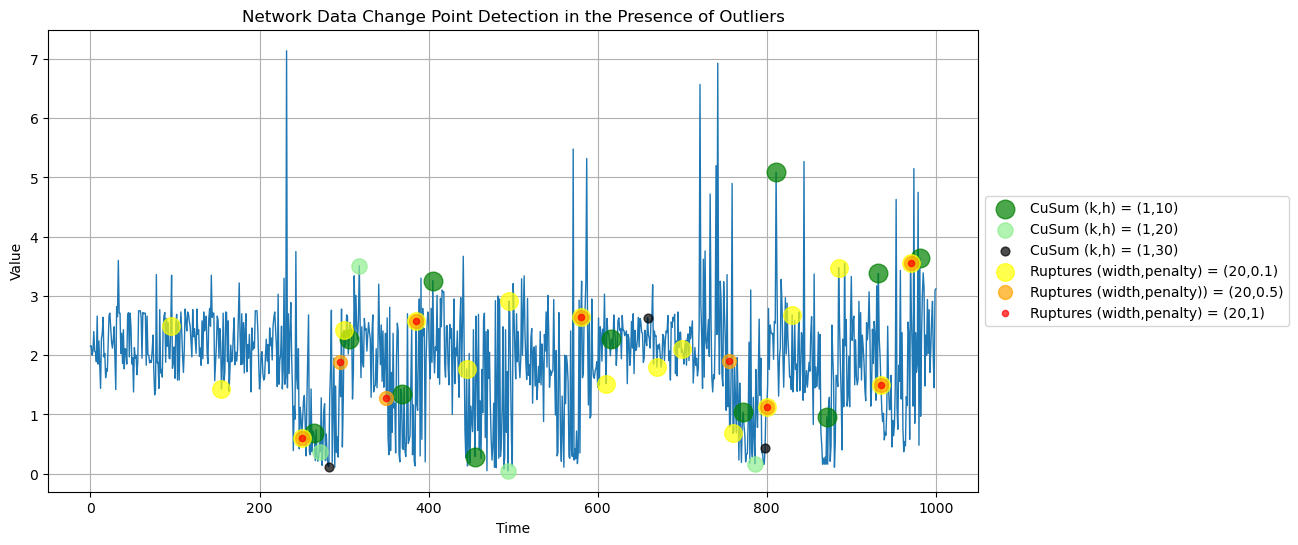

In [43]:
# Plot CuSum and Binary Segmentation best change point detections
plt.figure(figsize=(12, 6))

# CuSum change points
plt.scatter(valid_params_cusum[0]['cps'],
            [throughput[i] for i in valid_params_cusum[0]['cps']],
            color="green", label='CuSum (k,h) = (1,10)', s=180, alpha=0.7, zorder=5)

plt.scatter(valid_params_cusum[1]['cps'],
            [throughput[i] for i in valid_params_cusum[1]['cps']],
            color="lightgreen", label='CuSum (k,h) = (1,20)', s=120, alpha=0.7, zorder=5)

plt.scatter(valid_params_cusum[2]['cps'],
            [throughput[i] for i in valid_params_cusum[2]['cps']],
            color="black", label='CuSum (k,h) = (1,30)', s=40, alpha=0.7, zorder=5)

# Binary Segmentation change points
plt.scatter(valid_params_ruptures[0]['cps'],
            [throughput[i] for i in valid_params_ruptures[0]['cps']],
            color="yellow", label='Ruptures (width,penalty) = (20,0.1)', s=160, alpha=0.7, zorder=5)

plt.scatter(valid_params_ruptures[1]['cps'],
            [throughput[i] for i in valid_params_ruptures[1]['cps']],
            color="orange", label='Ruptures (width,penalty)) = (20,0.5)', s=100, alpha=0.7, zorder=5)

plt.scatter(valid_params_ruptures[2]['cps'],
            [throughput[i] for i in valid_params_ruptures[2]['cps']],
            color="red", label='Ruptures (width,penalty) = (20,1)', s=20, alpha=0.7, zorder=5)

# Plot original signal
plt.plot(throughput, linewidth=1)

plt.title("Network Data Change Point Detection in the Presence of Outliers")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


### R-FPOP

In [44]:
%%R -o valid_params_fpop -o best_detected_anomalies -o best_f1_fpop
require(robseg)

# Load network data with labels
data <- read.csv("network_dataset_labeled.csv", header = TRUE)
throughput_signal <- data[["throughput"]]
throughput_true_anomalies <- data[["anomaly_throughput"]]
source("Simulation.R")

# Estimate variance
est.sd <- varDiff(throughput_signal)

# Define parameter values
lthreshold_values <- c(2, 3, 4)
pen_value <- 2 * log(length(throughput_signal))

# Run R-FPOP on network data
valid_params_fpop <- list()
best_f1_fpop <- 0
best_detected_anomalies <- NULL
valid_params_fpop <- list()

for (lt in lthreshold_values) {
  res <- fpop_intern(throughput_signal / est.sd, test.stat = "Outlier",
                     pen.value = pen_value, lthreshold = lt)
  
  cpts <- res$cpts[-length(res$cpts)]
  outliers <- which(res$out)

  
  # Store valid params for CP detection
  if (length(cpts) < 20) {
    valid_params_fpop[[length(valid_params_fpop) + 1]] <- list(
      lthreshold = lt,
      num_cps = length(cpts),
      cpts = cpts,
      outliers = outliers,
      mean_signal = res$smt.signal
    )
  }
  
  # Evaluate anomaly detection F1-score
  predicted <- rep(0, length(throughput_true_anomalies))
  predicted[outliers] <- 1
  
  tp <- sum(predicted == 1 & throughput_true_anomalies == 1)
  fp <- sum(predicted == 1 & throughput_true_anomalies == 0)
  fn <- sum(predicted == 0 & throughput_true_anomalies == 1)
  
  precision <- tp / (tp + fp + 1e-9)
  recall <- tp / (tp + fn + 1e-9)
  f1 <- 2 * precision * recall / (precision + recall + 1e-9)
  
  if (f1 > best_f1_fpop) {
    best_f1_fpop <- f1
    best_detected_anomalies <- list(
      lthreshold = lt,
      f1 = f1,
      precision = precision,
      recall = recall,
      anomalies = outliers -1 # convert to 0-based indices for Python
    )
  }
}

# Print valid parameter sets
for (vp in valid_params_fpop) {
  cat(sprintf("lthreshold=%s -> %s change points\n", vp$lthreshold, vp$num_cps))
}


R[write to console]: Loading required package: robseg



lthreshold=2 -> 14 change points
lthreshold=3 -> 14 change points
lthreshold=4 -> 14 change points


In [45]:
print(f"The best F1-score by R-Fpop anomaly detection built-in algorithm {np.round(best_f1_fpop[0],3)}")

The best F1-score by R-Fpop anomaly detection built-in algorithm 0.509


In [46]:
# Extract change points from R list into Python variables 
cpt_fpop_1 = %R valid_params_fpop[[1]]$cpts
cpt_fpop_2 = %R valid_params_fpop[[2]]$cpts
cpt_fpop_3 = %R valid_params_fpop[[3]]$cpts
# Extract best detected anomalies from R list into Python variable
anomalies_fpop = %R best_detected_anomalies$anomalies

# Turn into Python sets for intersection
set1, set2, set3 = set(cpt_fpop_1), set(cpt_fpop_2), set(cpt_fpop_3)

# Pairwise overlaps
overlap_12 = len(set1 & set2)
overlap_13 = len(set1 & set3)
overlap_23 = len(set2 & set3)

print(f"Overlap 1 vs 2: {overlap_12}")
print(f"Overlap 1 vs 3: {overlap_13}")
print(f"Overlap 2 vs 3: {overlap_23}")

Overlap 1 vs 2: 9
Overlap 1 vs 3: 10
Overlap 2 vs 3: 11


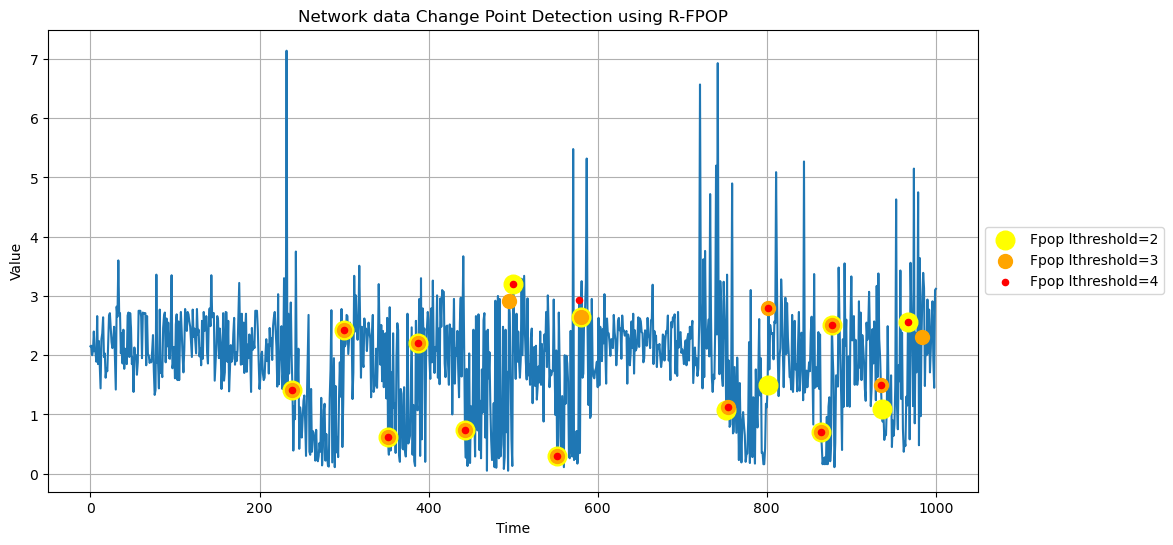

In [47]:
# Plot R-FPOP change point detections
plt.figure(figsize=(12, 6))

#plt.scatter(valid_params_cusum[0]['cps'], [throughput[i] for i in valid_params_cusum[0]['cps']], color = "green", label='CuSum (k,h) = (1,10)', zorder=5)

plt.scatter(cpt_fpop_1, [throughput[i] for i in cpt_fpop_1], 
            color='yellow', marker = 'o', s=180, label='Fpop lthreshold=2',  zorder=5)
plt.scatter(cpt_fpop_2, [throughput[i] for i in cpt_fpop_2], 
            color='orange', marker = 'o', s = 100, label='Fpop lthreshold=3',  zorder=5)
plt.scatter(cpt_fpop_3, [throughput[i] for i in cpt_fpop_3], 
            color='red', marker = 'o', s =20, label='Fpop lthreshold=4',  zorder=5)
plt.plot(throughput)
plt.title("Network data Change Point Detection using R-FPOP")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



# Anomaly Detection on Network Data

### LOF

In [48]:
# Local Outlier Factor Anomaly Detection
true_anomalies = {idx: None for idx in true_anomaly_indecies} # covert to labled dict accepted by tune_LOF and tune_kmeans
# Wrap throughput data into data generator function
def fixed_data_generator(seed=None):
    return throughput,_, true_anomalies
f1_lof_results_throughput, (lof_best_score,throuput_lof_anomalies) = tune_LOF(
    data_generating_function= fixed_data_generator, no_neighbours=[500, 600, 700, 800], contamination_range= [
        0.02,0.03, 0.04, 0.05], n_simulations=1, seed=12)

throuput_lof_anomalies = np.where(throuput_lof_anomalies == -1)[0]
print(f"The best F1-score achieved using LOF anomaly detection {np.round(lof_best_score,3)}")

The best F1-score achieved using LOF anomaly detection 0.901


### K-Means++

In [49]:
# KMeans++ Anomaly Detection
f1_kmeans_results_throughput, (kmeans_best_score, throuput_kmeans_anomalies) = tune_kmeans(
    data_generating_function= fixed_data_generator,
    percentile_range =[90,91,92,93,94,95,96,97,98,99],
    k_range=(2,3, 4, 5),
    n_simulations=1,
    seed=12)

throuput_kmeans_anomalies = list(throuput_kmeans_anomalies)

print(f"The best F1-score achieved using K-Means++ anomaly detection {np.round(kmeans_best_score,3)}.")

The best F1-score achieved using K-Means++ anomaly detection 0.732.


### K-Means++ on CuSum residuals

In [50]:
# Compute residuals based on the cps detected with CuSum
residual_datasets = []
for vp in valid_params_cusum:
    cps_indecies = vp['cps']
    start = 0
    residuals_after_cp = np.zeros_like(throughput)
    for cp in cps_indecies:
        segment = throughput[start:cp]
        segment_mean = np.mean(segment)
        residuals_after_cp[start:cp] = segment - segment_mean
        start = cp
    
    residual_datasets.append(residuals_after_cp)
        
best_f1 = 0
best_anomalies = None
best_results = None

for i, residual_data in enumerate(residual_datasets):
    def data_generator(seed=None, x=residual_data):  # Capture current dataset
        return x, None, true_anomalies

    f1_results, (f1_score, anomalies) = tune_kmeans(
        data_generating_function= data_generator,
        percentile_range =[91,92,93,94,95,96,97,98,99],
        k_range=(2,3,4,5,6,7),
        n_simulations=1,
        seed=12)

    if f1_score > best_f1:
        best_f1 = f1_score
        best_anomalies = anomalies
        best_results = f1_results

# Save the best detecion
throuput_cusumkmeans_anomalies = best_anomalies
cusumkmeans_best_score = best_f1

print(f"The best F1-score achieved using K-Means++ anomaly detection on CuSum residuals {np.round(cusumkmeans_best_score,3)}.")

The best F1-score achieved using K-Means++ anomaly detection on CuSum residuals 0.651.


### K-Means++ on R-Fpop residuals

In [51]:
# Extract change points from R list into Python variables 
cpt_fpop_1 = %R valid_params_fpop[[1]]$cpts
cpt_fpop_2 = %R valid_params_fpop[[2]]$cpts
cpt_fpop_3 = %R valid_params_fpop[[3]]$cpts

# Generate residuals for each set of detected change points
cps_sets = [cpt_fpop_1, cpt_fpop_2, cpt_fpop_3]
cps_sets = [[cp - 1 for cp in cpt] for cpt in cps_sets] # convert to 0-based indices for Python
residual_datasets = []
for cps_indecies in cps_sets:
    start = 0
    residuals_after_cp = np.zeros_like(throughput)
    for cp in cps_indecies:
        segment = throughput[start:cp]
        segment_mean = np.median(segment)
        residuals_after_cp[start:cp] = (segment - np.mean(segment)) / np.std(segment)
        start = cp
    if start < len(throughput):
        segment = throughput[start:]
        segment_mean = np.mean(segment)
        residuals_after_cp[start:] = segment - segment_mean
    residual_datasets.append(residuals_after_cp)
        
best_f1 = 0
best_anomalies = None
best_results = None

# Run K-Means++ on the residuals
for i, residual_data in enumerate(residual_datasets):
    def data_generator(seed=None, x=residual_data):  # Capture current dataset
        return x, None, true_anomalies

    f1_results, (f1_score, anomalies) = tune_kmeans(
        data_generating_function= data_generator,
        percentile_range =[90,91,92,93,94, 95,96,97,98,99],
        k_range=(2,3,3,4,5,6,7),
        n_simulations=1,
        seed=12)

    if f1_score > best_f1:
        best_f1 = f1_score
        best_anomalies = anomalies
        best_results = f1_results
        

# Save the best detecion
outliers_fpoplof = best_anomalies
fpopkmeans_best_score = best_f1
print(f"The best F1-score achieved using K-Means++ anomaly detection on R-FPOP residuals {np.round(fpopkmeans_best_score,3)}.")


The best F1-score achieved using K-Means++ anomaly detection on R-FPOP residuals 0.419.


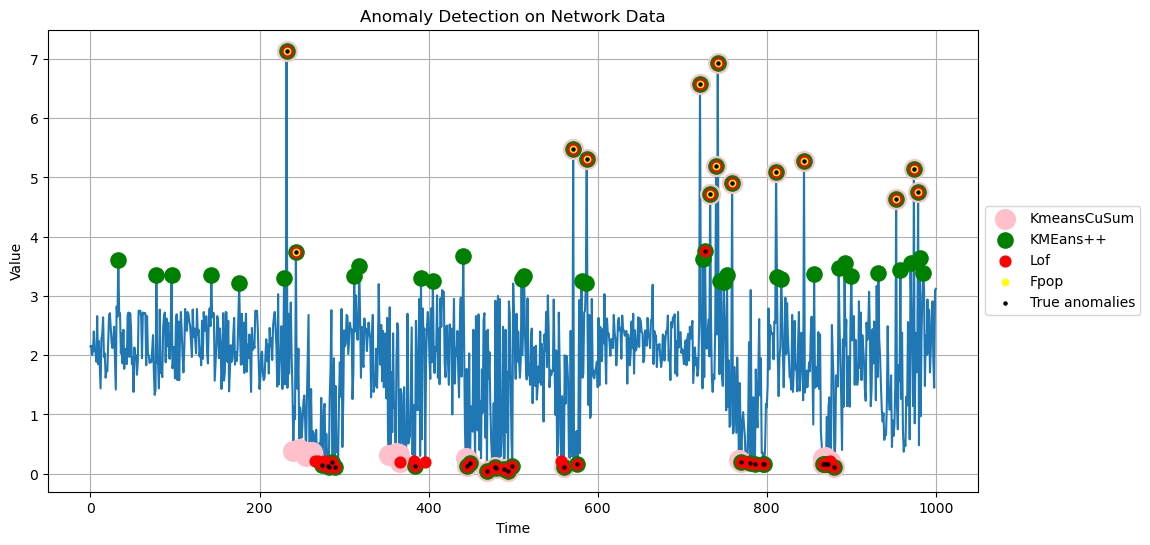

In [52]:
# Plot Network Data anomaly detection
plt.figure(figsize=(12, 6))
# KMeans++ on CuSum residuals
plt.scatter(list(throuput_cusumkmeans_anomalies), [throughput[int(i)] for i in list(throuput_cusumkmeans_anomalies)],
            color = "pink",s = 200, label='KmeansCuSum', zorder=5)
# KMeans++
plt.scatter(list(throuput_kmeans_anomalies), [throughput[i] for i in list(throuput_kmeans_anomalies)],
            color = "green",s = 120, label='KMEans++', zorder=5) 
# LOF
plt.scatter(throuput_lof_anomalies, [throughput[i] for i in throuput_lof_anomalies], 
            color='red', marker = 'o',s = 60, label='Lof',  zorder=5)
# Fpop bulit-in anomaly deteciton algorithm
plt.scatter(anomalies_fpop, [throughput[int(i)] for i in anomalies_fpop],
            color = "yellow",s = 20, label='Fpop', zorder=5)
# True anomalies
plt.scatter(true_anomaly_indecies, [throughput[i] for i in true_anomaly_indecies],
            color = "black",s = 5, label='True anomalies', zorder=5)
plt.plot(throughput)
plt.title("Anomaly Detection on Network Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



# LOF/ K-Means++ on Fpop residuals - synthetic data

## Generate synthetic datasets

In [53]:
data_w_cps = generate_data_w_change_points(mu_choices=[1, 5], std_signal=1, 
                                total_length=1000, seed=110)
synthetic_signal, synthetic_cps, synthetic_anomalies = generate_data_w_change_points_and_anomalies(
       data_w_cps,
        seed=12,
        n_individual_anomalies=50,
        n_clusters=0,
        cluster_size=0,
        anomaly_std=2,
    indiv_anomal_mean = -5
    
)

synthetic_anomalies = {idx: None for idx in synthetic_anomalies} # covert to labled dict accepted by tune_LOF and tune_kmeans

# Save synthetic signal as CSV
pd.DataFrame({"signal": synthetic_signal}).to_csv("synthetic_signal.csv", index=False)

# Save changepoints as CSV
pd.DataFrame({"changepoints": synthetic_cps}).to_csv("synthetic_cps.csv", index=False)

# Create a 0-initialized array the same length as the signal
anomaly_labels = np.zeros(len(synthetic_signal), dtype=int)

# Set anomalies to 1
anomaly_labels[list(synthetic_anomalies.keys())] = 1

# Save anomalies as CSV
pd.DataFrame({"anomaly": anomaly_labels}).to_csv("synthetic_anomalies_labels.csv", index=False)

In [54]:
print(f"The synthetic data consist of {len(synthetic_cps)} change points and {len(synthetic_anomalies)} anomalies.")

The synthetic data consist of 16 change points and 50 anomalies.


### Local Outlier Factor Anomaly Detection

In [55]:

# Wrap synthetic data into data generator function
def fixed_synthetic_data_generator(seed=None):
    return synthetic_signal,_, synthetic_anomalies
f1_lof_results_s, (lof_best_score_s,s_lof_anomalies) = tune_LOF(
    data_generating_function= fixed_synthetic_data_generator,
    no_neighbours=[50, 100,200, 300, 400, 500, 600, 700],
    contamination_range= [0.04, 0.05, 0.06, 0.07],
    n_simulations=1,
    seed=12)

s_lof_anomalies = np.where(s_lof_anomalies == -1)[0]
print(f"The best F1-score achieved using LOF anomaly detection {np.round(lof_best_score_s,3)}")

The best F1-score achieved using LOF anomaly detection 0.433


### R-FPOP Anomaly and Change Point Detection

In [56]:
%%R -o valid_params_fpop_synthetic -o best_detected_anomalies_synthetic -o best_f1_fpop_synthetic
require(robseg)

# Load data

signal <- read.csv("synthetic_signal.csv", header = TRUE)
true_anomalies <- read.csv("synthetic_anomalies_labels.csv", header = TRUE)
true_cps <- read.csv("synthetic_cps.csv", header = TRUE)
source("Simulation.R")

n <- length(signal$signal)

# Estimate variance
est.sd <- varDiff(signal$signal)

# Define parameter values
lthreshold_values <- c(3, 4, 5)
pen_value <- 2 * log(length(signal$signal))
valid_params_fpop_synthetic <- list()
best_f1_fpop_synthetic <- 0
best_detected_anomalies_synthetic <- NULL
valid_params_fpop_synthetic <- list()

for (lt in lthreshold_values) {
  res <- fpop_intern(signal$signal / est.sd, test.stat = "Outlier",
                     pen.value = pen_value, lthreshold = lt)
  
  cpts <- res$cpts[-length(res$cpts)]
  outliers <- which(res$out)

  
  # Store valid params for CPD
    valid_params_fpop_synthetic[[length(valid_params_fpop_synthetic) + 1]] <- list(
      lthreshold = lt,
      num_cps = length(cpts),
      cpts = cpts,
      outliers = outliers,
      mean_signal = res$smt.signal
    )
  
  # Evaluate anomaly detection F1-score
  predicted <- rep(0, length(true_anomalies))
  predicted[outliers] <- 1
  
  tp <- sum(predicted == 1 & true_cps$changepoint == 1)
  fp <- sum(predicted == 1 & true_cps$changepoint == 0)
  fn <- sum(predicted == 0 & true_cps$changepoint == 1)
  
  precision <- tp / (tp + fp + 1e-9)
  recall <- tp / (tp + fn + 1e-9)
  f1 <- 2 * precision * recall / (precision + recall + 1e-9)
  
  if (f1 > best_f1_fpop_synthetic) {
    best_f1_fpop_synthetic <- f1
    best_detected_anomalies_synthetic <- list(
      lthreshold = lt,
      f1 = f1,
      precision = precision,
      recall = recall,
      anomalies = outliers -1 # convert to 0-based indices for Python
    )
  }
}

# Print valid parameter sets
for (vp in valid_params_fpop_synthetic) {
  cat(sprintf("lthreshold=%s -> %s change points\n", vp$lthreshold, vp$num_cps))
}


lthreshold=3 -> 8 change points
lthreshold=4 -> 8 change points
lthreshold=5 -> 10 change points


In [57]:
print(f"The best F1-score by Fpop anomaly detection by built-in algorithm {np.round(best_f1_fpop_synthetic[0],3)}")

The best F1-score by Fpop anomaly detection by built-in algorithm 0.0


### LOF Anomaly Detection on R-FPOP residuals

In [58]:
# Extract change points from R list into Python variables 
cpt_fpop_1 = %R valid_params_fpop_synthetic[[1]]$cpts
cpt_fpop_2 = %R valid_params_fpop_synthetic[[2]]$cpts
cpt_fpop_3 = %R valid_params_fpop_synthetic[[3]]$cpts

# Generate residuals for each set of detected change points
cps_sets = [cpt_fpop_1, cpt_fpop_2, cpt_fpop_3]
cps_sets = [[cp - 1 for cp in cpt] for cpt in cps_sets] # convert to 0-based indices for Python
residual_datasets = []
for cps_indecies in cps_sets:
    start = 0
    residuals_after_cp = np.zeros_like(synthetic_signal)
    for cp in cps_indecies:
        segment = synthetic_signal[start:cp]
        segment_mean = np.median(segment)
        residuals_after_cp[start:cp] = (segment - np.mean(segment))
        start = cp
    if start < len(synthetic_signal):
        segment = synthetic_signal[start:]
        segment_mean = np.mean(segment)
        residuals_after_cp[start:] = segment - segment_mean
    residual_datasets.append(residuals_after_cp)
        
best_f1 = 0
best_anomalies = None
best_results = None


for i, residual_data in enumerate(residual_datasets):
    def data_generator(seed=None, x=residual_data):  # Capture current dataset
        return x, None, synthetic_anomalies

    f1_results, (f1_score, anomalies) = tune_LOF(
    data_generating_function= data_generator, no_neighbours=[50, 100,200, 300, 400, 500, 600, 700],
        contamination_range= [0.04, 0.05, 0.06, 0.07],
        n_simulations=1, seed=12)

    if f1_score > best_f1:
        best_f1 = f1_score
        best_anomalies = anomalies
        best_results = f1_results

# Save the best detecion
s_lof_anomalies_fpop = best_anomalies
s_lof_anomalies_fpop = np.where(s_lof_anomalies_fpop== -1) # get anomaly indices
fpoplof_best_score = best_f1

print(f"The best F1-score achieved using LOF anomaly detection on R-FPOP residuals {np.round(fpoplof_best_score,3)}.")

The best F1-score achieved using LOF anomaly detection on R-FPOP residuals 0.8.


### K-Means++ Anomaly Detection

In [59]:
### K-Means++
f1_kmeans_results_throughput, (kmeans_best_score, throuput_kmeans_anomalies) = tune_kmeans(
    data_generating_function= fixed_synthetic_data_generator,
    percentile_range =[90,91,92,93,94,95,96,97,98,99],
    k_range=(2,3, 4, 5),
    n_simulations=1,
    seed=12)

s_kmeans_anomalies = list(throuput_kmeans_anomalies)

print(f"The best F1-score achieved using K-Means++ anomaly detection {np.round(kmeans_best_score,3)}.")


The best F1-score achieved using K-Means++ anomaly detection 0.575.


### K-Means++ Anomaly Detection on R-FPOP residuals

In [60]:
for i, residual_data in enumerate(residual_datasets):
    def data_generator(seed=None, x=residual_data):  # Capture current dataset
        return x, None, synthetic_anomalies

    f1_results, (f1_score, anomalies) = tune_kmeans(
    data_generating_function= data_generator,
    percentile_range =[90,91,92,93,94,95,96,97,98,99],
    k_range=(2,3, 4, 5),
    n_simulations=1,
    seed=12)

print(f"The best F1-score achieved using K-Means++ anomaly detection on R-FPOP residuals {np.round(f1_score,3)}.")

The best F1-score achieved using K-Means++ anomaly detection on R-FPOP residuals 0.275.


In [61]:
# Compute precision and recall of K-Means++ detection on the synthetic data
n = len(synthetic_signal)

# True anomaly indices
true_anomalies = np.array(list(synthetic_anomalies))
# Predicted anomaly indices
pred_anomalies = np.array(list(throuput_kmeans_anomalies))

# Convert to binary label arrays
y_true = np.zeros(n, dtype=int)
y_true[true_anomalies] = 1
y_pred = np.zeros(n, dtype=int)
y_pred[pred_anomalies] = 1

# Compute metrics
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
print(f"The precision and recall achieved using K-Means++ anomaly detection is {np.round(p,3)} and {np.round(r,3)} respectively.")

The precision and recall achieved using K-Means++ anomaly detection is 0.767 and 0.46 respectively.


In [62]:
# Compute precision and recall of K-Means++ Anomaly Detection on R-FPOP residuals
# Predicted anomaly indices
pred_anomalies = np.array(list(anomalies))

# Convert to binary label arrays
y_true = np.zeros(n, dtype=int)
y_true[true_anomalies] = 1
y_pred = np.zeros(n, dtype=int)
y_pred[pred_anomalies] = 1

# Compute metrics
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
print(f"The precision and recall achieved using K-Means++ anomaly detection on R-FPOP residuals is {np.round(p,3)} and {np.round(r,3)} respectively.")

The precision and recall achieved using K-Means++ anomaly detection on R-FPOP residuals is 0.367 and 0.22 respectively.


In [63]:
# Compute precision and recall of LOF detection on the synthetic data
# Predicted anomaly indices
pred_anomalies = np.array(list(s_lof_anomalies))

# Convert to binary label arrays
y_true = np.zeros(n, dtype=int)
y_true[true_anomalies] = 1
y_pred = np.zeros(n, dtype=int)
y_pred[pred_anomalies] = 1

# Compute metrics
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
print(f"The precision and recall achieved using LOF anomaly detection is {np.round(p,3)} and {np.round(r,3)} respectively.")

The precision and recall achieved using LOF anomaly detection is 0.371 and 0.52 respectively.


In [64]:
# Compute precision and recall of LOF Anomaly Detection on R-FPOP residuals
# Predicted anomaly indices
pred_anomalies = np.array(list(s_lof_anomalies_fpop))

# Convert to binary label arrays
y_true = np.zeros(n, dtype=int)
y_true[true_anomalies] = 1
y_pred = np.zeros(n, dtype=int)
y_pred[pred_anomalies] = 1

# Compute metrics
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
print(f"The precision and recall achieved using LOF anomaly detection on R-FPOP residuals is {np.round(p,3)} and {np.round(r,3)} respectively.")



The precision and recall achieved using LOF anomaly detection on R-FPOP residuals is 0.686 and 0.96 respectively.
